In [105]:
import pickle
import random

import pandas as pd
import numpy as np
from matplotlib import pyplot as pt
from scipy.stats import f
from scipy import optimize
from scipy import stats as st
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_validation import cross_val_score

%matplotlib inline

In [4]:
def stringify_position(position):
    
    if position < 10:
        pos = "0%d" % position
    else:
        pos = str(position)
        
    return pos

## 1. Cyll cycle length analysis

In [5]:
dat_tg = pickle.load(open("../results/unsyn_two_generation.p", "rb" ))

In [6]:
## copied global_analysis.py

lifetimes = {}
for p in set(list(range(56))[48:]) - set([4, 5, 11, 13, 19, 20, 37, 38, 44, 53, 54, 60]):
    pos = stringify_position(p)
    for tr in dat_tg[pos]["TREES"]:
        child1 = dat_tg[pos]["TREES"][tr]["BRANCH"][tr][0]
        child2 = dat_tg[pos]["TREES"][tr]["BRANCH"][tr][1]
        last_time =  dat_tg[pos]["TREES"][tr]["POSITION_T"][tr][-1]
        first_time1 = (last_time + dat_tg[pos]["TREES"][tr]["POSITION_T"][child1][0]) / 2.
        first_time2 = (dat_tg[pos]["TREES"][tr]["POSITION_T"][child2][0]) / 2.
        last_time1 = dat_tg[pos]["TREES"][tr]["POSITION_T"][child1][-1]
        last_time2 = dat_tg[pos]["TREES"][tr]["POSITION_T"][child2][-1]
        
        if pos not in lifetimes:
            lifetimes[pos] = [last_time1 - first_time1]
        else:
            lifetimes[pos].append(last_time1 - first_time1)
        lifetimes[pos].append(last_time2 - first_time2)

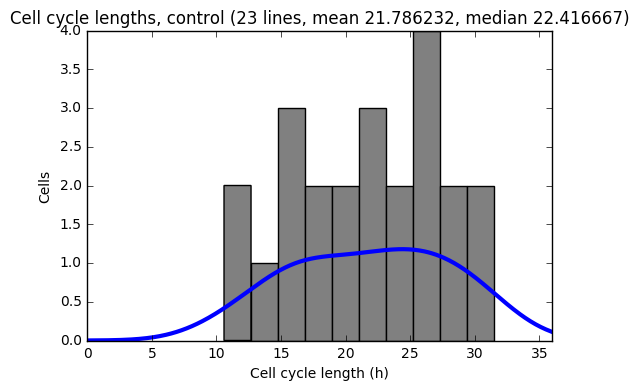

In [205]:
tim = pd.read_csv("../results/unsyn_ccyclel.csv",index_col=0)
tim = tim[(tim.POSITION >= 48) & (tim.POSITION <= 55)]

pt.hist(tim.TIME, color="gray", bins=10)
pt.xlim(0, 36)
pt.title("Cell cycle lengths, control (%d lines, mean %f, median %f)" % (tim.index.size, np.mean(tim.TIME), np.median(tim.TIME)))
pt.ylabel("Cells")
pt.xlabel("Cell cycle length (h)")

## plot KDE
kde = stats.gaussian_kde(tim.TIME)
x = np.arange(0, 36, .1)
y = [v * tim.index.size for v in kde(x)]
pt.plot(x, y, 'b', linewidth=3)

pt.savefig("D:/Dropbox/Edu/MA/20171022_results/images/cell_cycle/unsyn_cell_cycle_length_control.pdf")

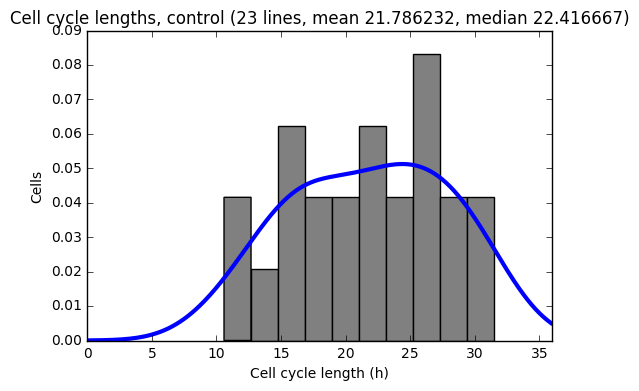

In [207]:
pt.hist(tim.TIME, color="gray", bins=10, normed=True)
pt.xlim(0, 36)
pt.title("Cell cycle lengths, control (%d lines, mean %f, median %f)" % (tim.index.size, np.mean(tim.TIME), np.median(tim.TIME)))
pt.ylabel("Cells")
pt.xlabel("Cell cycle length (h)")

## plot KDE
kde = stats.gaussian_kde(tim.TIME)
x = np.arange(0, 36, .1)
pt.plot(x, kde(x), 'b', linewidth=3)

pt.savefig("D:/Dropbox/Edu/MA/20171022_results/images/cell_cycle/unsyn_cell_cycle_length_control_normed.pdf")

In [208]:
dat_tg_us = pickle.load(open("../results/syn_two_generation.p", "rb" ))

# 2. TIC vs TTD

In [8]:
##load pickle
dat_f = pickle.load(open("../results/unsyn_filtered_data_divided_before_treatment.p", "rb"))

In [9]:
##load pickle
dat_ds = pickle.load(open("../results/unsyn_filtered_data_pi_sub.p", "rb"))

In [10]:
## copied global_analysis.py

## create reverse lookup for slit in PI video

slit_tree_map_ds = {}

for pos in dat_ds:
    slit_tree_map_ds[pos] = {}
    for tr in dat_ds[pos]['TREES']:
        slit_id = dat_ds[pos]['TREES'][tr]['SLIT_ID']
        if slit_id not in slit_tree_map_ds[pos]:
            slit_tree_map_ds[pos][slit_id] = [tr]
        else:
            slit_tree_map_ds[pos][slit_id].append(tr)

In [11]:
## copied global_analysis.py

## create reverse lookup for slit in BF video

slit_tree_map_bf = {}

for pos in dat_f:
    slit_tree_map_bf[pos] = {}
    for tr in dat_f[pos]['TREES']:
        slit_id = dat_f[pos]['TREES'][tr]['SLIT_ID']
        if slit_id not in slit_tree_map_bf[pos]:
            slit_tree_map_bf[pos][slit_id] = [tr]
        else:
            slit_tree_map_bf[pos][slit_id].append(tr)
            
            

In [12]:
## copied global_analysis.py

correlation_analysis = {}
ttd_analysis = {}
ttd_analysis_double = {}

for pos in slit_tree_map_ds.keys():
    correlation_analysis[pos] = []
    ttd_analysis[pos] = []
    ttd_analysis_double[pos] = []
    for slit_id in slit_tree_map_ds[pos]:
        if slit_id in slit_tree_map_bf[pos]:
            
            ## double track == TTD and correlation
            if len(slit_tree_map_ds[pos][slit_id]) == 2:
                
                # extract div time from BF tree
                tr = slit_tree_map_bf[pos][slit_id][0]
#                 tr_div_time = dat_fat[pos]['TREES'][tr]['POSITION_T'][tr][-1]
                tr_div_time = dat_f[pos]['TREES'][tr]['POSITION_T'][tr][-1]
                
                # extract death time from DS tree I and II
                tr_ds_1 = slit_tree_map_ds[pos][slit_id][0]
                tr_ds_2 = slit_tree_map_ds[pos][slit_id][1]
                tr_death_time_1 = dat_ds[pos]['TREES'][tr_ds_1]['POSITION_T'][tr_ds_1][1]
                tr_death_time_2 = dat_ds[pos]['TREES'][tr_ds_2]['POSITION_T'][tr_ds_2][1]
                correlation_analysis[pos].append((tr_div_time, tr_death_time_1, tr_death_time_2))
                ttd_analysis[pos].append((tr_div_time, tr_death_time_1))
                ttd_analysis[pos].append((tr_div_time, tr_death_time_2))
                ttd_analysis_double[pos].append((tr_div_time, tr_death_time_1))
                ttd_analysis_double[pos].append((tr_div_time, tr_death_time_2))
                
            elif len(slit_tree_map_ds[pos][slit_id]) == 1:
                
                # extract div time from BF tree
                tr = slit_tree_map_bf[pos][slit_id][0]
#                 tr_div_time = dat_fat[pos]['TREES'][tr]['POSITION_T'][tr][-1]
                tr_div_time = dat_f[pos]['TREES'][tr]['POSITION_T'][tr][-1]
                
                # extract death time from DS tree
                tr_ds = slit_tree_map_ds[pos][slit_id][0]
                tr_death_time = dat_ds[pos]['TREES'][tr_ds]['POSITION_T'][tr_ds][1]
                
                ttd_analysis[pos].append((tr_div_time, tr_death_time))

In [13]:
treatment_mapping = {}
for pos in list(range(1, 9)):treatment_mapping[pos] = 1
for pos in list(range(9, 16)):treatment_mapping[pos] = 2
for pos in list(range(16, 24)):treatment_mapping[pos] = 3
for pos in list(range(24, 32)):treatment_mapping[pos] = 4
for pos in list(range(32, 40)):treatment_mapping[pos] = 5
for pos in list(range(40, 48)):treatment_mapping[pos] = 6
for pos in list(range(48, 56)):treatment_mapping[pos] = 7
for pos in list(range(56, 64)):treatment_mapping[pos] = 8

In [52]:
## flatten the data structure

positions = []
division_times = []
death_times = []
treatments = []

for pos in ttd_analysis:
    div_times_p = [e[0] for e in ttd_analysis[pos]]
    dth_times_p = [e[1] for e in ttd_analysis[pos]]
    pos_p = [int(pos)] * len(div_times_p)
    trt_p = [treatment_mapping[int(pos)]] * len(div_times_p)
    
    positions += pos_p
    division_times += div_times_p
    death_times += dth_times_p
    treatments += trt_p
    
division_times = [x / 3600. for x in division_times]
death_times = [x / 3600. for x in death_times]
    
dat = pd.DataFrame({"POSITION": positions, 
                    "DIVISION_TIME": division_times, 
                    "DEATH_TIME": death_times,
                    "TREATMENT": treatments})
dat["TIME_IN_CYCLE"] = 21 - dat.DIVISION_TIME
dat["TIME_TO_DEATH"] = dat.DEATH_TIME - 21

dat = dat[dat.DEATH_TIME >= 21]
dat = dat.reset_index(drop=True)

In [164]:
dat.head()

,DEATH_TIME,DIVISION_TIME,POSITION,TREATMENT,TIME_IN_CYCLE,TIME_TO_DEATH
0,26.5,13.333333,2,1,7.666667,5.5
1,30.0,6.166667,2,1,14.833333,9.0
2,26.5,0.833333,2,1,20.166667,5.5
3,38.0,0.166667,2,1,20.833333,17.0
4,39.5,0.166667,2,1,20.833333,18.5


In [57]:
## 

treatments = []
cutoffs = []
pvals = []

for trtmt in dat.TREATMENT.unique():
    dat_t = dat[dat.TREATMENT == trtmt]
    
    for co in np.arange(1, 22, 1):
        
        s1 = dat_t[dat_t.TIME_IN_CYCLE < co]["TIME_TO_DEATH"]
        s2 = dat_t[dat_t.TIME_IN_CYCLE >= co]["TIME_TO_DEATH"]
        
        F = np.var(s1) / (np.var(s2) + .000000001)
        
        df1 = len(s1) - 1
        df2 = len(s2) - 1

        p_value = f.sf(F, df1, df2)
        
        treatments.append(trtmt)
        cutoffs.append(co)
        pvals.append(p_value)        
        
f_results = pd.DataFrame({"TREATMENT": treatments,
                          "CUTOFF": cutoffs, 
                          "P_VAL": pvals})

In [58]:
cmap = {1:'#1f77b4',
       2:'#ff7f0e',
       3:'#2ca02c',
       4:'#d62728',
       5:'#9467bd',
       6:'#8c564d',
       7:'#e377c2',
       8:'#7f7f7f'}

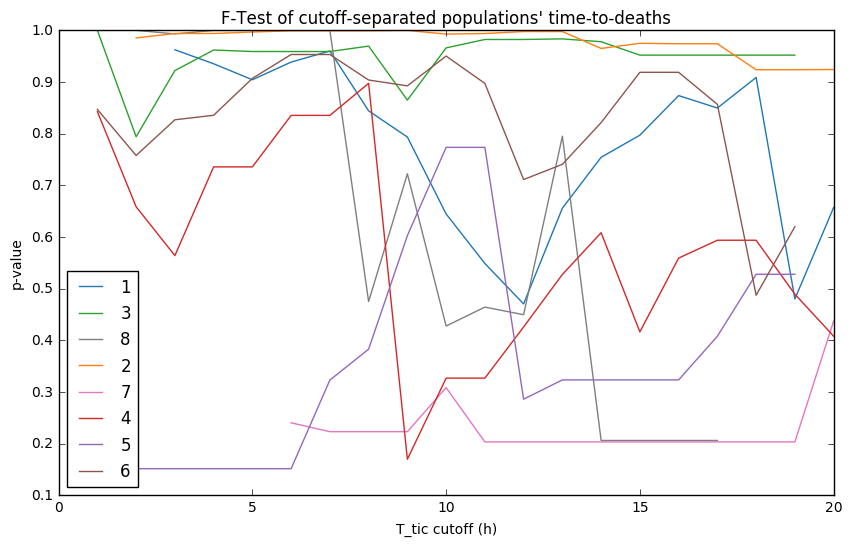

In [116]:
for tr in f_results.TREATMENT.unique():
    
    fr_t = f_results[f_results.TREATMENT == tr]
    
    x = fr_t.CUTOFF
#     xnew = np.linspace(x.min(), x.max(), 300)
    
    y = fr_t.P_VAL
#     y = spline(x, y, xnew)
    
    pt.plot(x, y, label=str(tr), c=cmap[tr])
pt.title("F-Test of cutoff-separated populations' time-to-deaths")
pt.xlabel("T_tic cutoff (h)")
pt.ylabel("p-value")
pt.gcf().set_size_inches(10, 6)
pt.legend(loc="best")

## Comparison of MSE and R2 of break point regression

In [148]:
treatments = []
cutoffs = []
mse_1 = []
r2_1 = []
mse_2 = []
r2_2 = []
r2_default = []
mse_default = []

for tr in f_results.TREATMENT.unique():
    
    dat_t = dat[dat.TREATMENT == trtmt]
    
    x = dat_t.TIME_IN_CYCLE.values
    x = x.reshape(x.size, 1)
    y = dat_t.DEATH_TIME.values
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    yp = regr.predict(x)
    mse_default += ([mean_squared_error(y, yp)] * 21)
    r2_default += ([r2_score(y, yp)] * 21)
    
    
    for co in np.arange(1, 22, 1):
        
        treatments.append(tr)
        cutoffs.append(co)
        
        regr1 = linear_model.LinearRegression()
        regr2 = linear_model.LinearRegression()
    
        x1 = dat_t[dat_t.TIME_IN_CYCLE < co]["TIME_IN_CYCLE"]
        x1 = np.array([v + random.gauss(0, 0.001) for v in x1])
        x1 = x1.reshape(x1.size, 1)
        
        x2 = dat_t[dat_t.TIME_IN_CYCLE >= co]["TIME_IN_CYCLE"]
        x2 = np.array([v + random.gauss(0, 0.001) for v in x2])
        x2 = x2.reshape(x2.size, 1)
        
        y1 = dat_t[dat_t.TIME_IN_CYCLE < co]["DEATH_TIME"]
        y1 = np.array([v + random.gauss(0, 0.001) for v in y1])
        
        y2 = dat_t[dat_t.TIME_IN_CYCLE >= co]["DEATH_TIME"]
        y2 = np.array([v + random.gauss(0, 0.001) for v in y2])
        
        if x1.size > 0:
            regr1 = linear_model.LinearRegression()
            regr1.fit(x1, y1)
            y1p = regr1.predict(x1)
            mse_1.append(mean_squared_error(y1, y1p))
            r2_1.append(r2_score(y1, y1p))
        else:
            mse_1.append(None)
            r2_1.append(None)
        
        if x2.size > 0:
            regr2 = linear_model.LinearRegression()
            regr2.fit(x2, y2)
            y2p = regr1.predict(x2)
            mse_2.append(mean_squared_error(y2, y2p))
            r2_2.append(r2_score(y2, y2p))
        else:
            mse_2.append(None)
            r2_2.append(None)
            
ls_results = pd.DataFrame({"TREATMENT": treatments, 
                          "CUTOFF": cutoffs, 
                          "MSE_1": mse_1, 
                          "R2_1": r2_1, 
                          "MSE_2": mse_2, 
                          "R2_2": r2_2})
ls_results["MSE_TOTAL"] = ls_results.MSE_1 + ls_results.MSE_2
ls_results["R2_COMBINED_GEOM_MEAN"] = np.nan
sel = (ls_results["R2_1"] >= 0) & (ls_results["R2_2"] > 0) 
ls_results[sel]["R2_COMBINED_GEOM_MEAN"] = np.sqrt(ls_results[sel]["R2_1"] * ls_results[sel]["R2_1"])
ls_results["R2_NO_CUTOFF"] = r2_default
ls_results["MSE_NO_CUTOFF"] = mse_default

In [149]:
ls_results

,CUTOFF,MSE_1,MSE_2,R2_1,R2_2,TREATMENT,MSE_TOTAL,R2_COMBINED_GEOM_MEAN,R2_NO_CUTOFF,MSE_NO_CUTOFF
0,1,1.262177e-28,1.603698e+08,1.000000,-6.030955e+06,1,1.603698e+08,NaN,0.026901,24.984991
1,2,6.664824e-01,9.956303e+03,0.909826,-3.747377e+02,1,9.956969e+03,NaN,0.026901,24.984991
2,3,7.496457e+00,4.573188e+02,0.260598,-1.581273e+01,1,4.648153e+02,NaN,0.026901,24.984991
3,4,1.189349e+01,1.032067e+02,0.047717,-2.785466e+00,1,1.151001e+02,NaN,0.026901,24.984991
4,5,1.294434e+01,3.634457e+01,0.002277,-2.867458e-01,1,4.928891e+01,NaN,0.026901,24.984991
5,6,1.188955e+01,3.086670e+01,0.000130,-5.331553e-02,1,4.275625e+01,NaN,0.026901,24.984991
6,7,1.189084e+01,3.087641e+01,0.000127,-5.355522e-02,1,4.276725e+01,NaN,0.026901,24.984991
7,8,1.703376e+01,3.245323e+01,0.025516,-6.643985e-02,1,4.948699e+01,NaN,0.026901,24.984991
8,9,1.807543e+01,4.027252e+01,0.006204,-3.465398e-01,1,5.834796e+01,NaN,0.026901,24.984991
9,10,1.634065e+01,4.838066e+01,0.013306,-5.320895e-01,1,6.472131e+01,NaN,0.026901,24.984991


In [98]:
ls_results.to_csv("../results/unsyn_breakpoint_analysis.csv")

## Piecewise regression

In [159]:
for tr in dat.TREATMENT.unique():

    x = np.array(dat[dat.TREATMENT == tr]["TIME_IN_CYCLE"])
    y = np.array(dat[dat.TREATMENT == tr]["DEATH_TIME"])

    def piecewise_linear(x, x0, y0, k1, k2):
        return np.piecewise(x, [x < x0], [lambda x:y0 + k1 * x - k1 * x0, lambda x:y0 + k2 * x - k2 * x0])

    p , e = optimize.curve_fit(piecewise_linear, x, y)
    xd = np.linspace(0, 25, 100)
    pt.plot(x, y, "o")
    pt.plot(xd, piecewise_linear(xd, *p))
    pt.title("Treatment %s" % tr)
    pt.xlabel("T_tic (h)")
    pt.ylabel("T_ttd (h)")
    
    pt.gcf().set_size_inches(6, 4)
    pt.savefig("piecewise_%d.pdf" % tr)
    pt.close()
    

C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## TTD sister correlations analysis

In [168]:
us_ttd_corr = pd.read_csv("../results/unsyn_sister_death_corr.csv", index_col=0)
s_ttd_corr = pd.read_csv("../results/syn_sister_death_corr.csv", index_col=0)

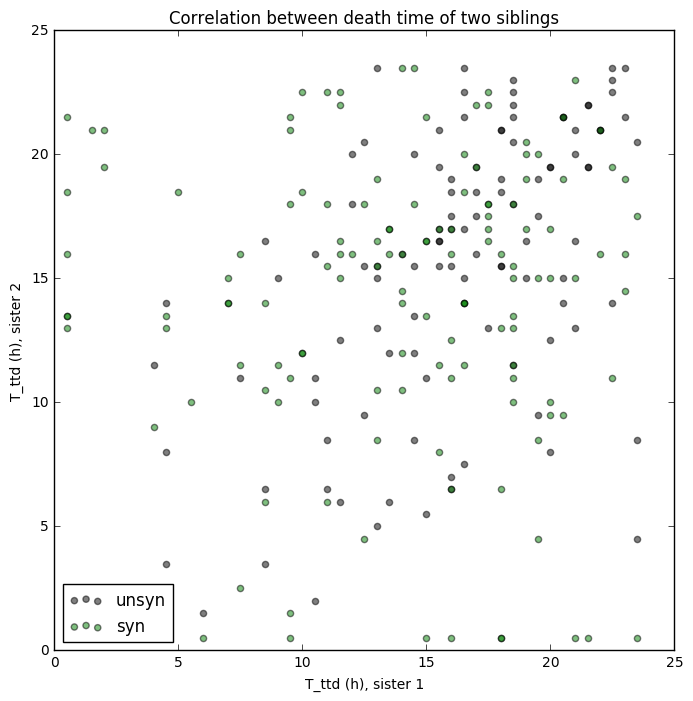

In [200]:
pt.scatter(us_ttd_corr.SISTER_1, us_ttd_corr.SISTER_2, c="black", label="unsyn", alpha=0.5)
pt.scatter(s_ttd_corr.SISTER_1, s_ttd_corr.SISTER_2, c="green", label="syn", alpha=0.5)

pt.legend(loc="lower left")
pt.title("Correlation between death time of two siblings")
pt.xlabel("T_ttd (h), sister 1")
pt.ylabel("T_ttd (h), sister 2")

pt.xlim(0, 25)
pt.ylim(0, 25)
pt.gcf().set_size_inches(8, 8)

pt.savefig("D:/Dropbox/Edu/MA/20171022_results/images/comp/ttd_corr_comp_blackgreen.pdf")

In [199]:
pt.scatter(us_ttd_corr.SISTER_1, us_ttd_corr.SISTER_2, c="red", label="unsyn", alpha=0.5)
pt.scatter(s_ttd_corr.SISTER_1, s_ttd_corr.SISTER_2, c="black", label="syn", alpha=0.5)

pt.legend(loc="lower left")
pt.title("Correlation between death time of two siblings")
pt.xlabel("T_ttd (h), sister 1")
pt.ylabel("T_ttd (h), sister 2")

pt.xlim(0, 25)
pt.ylim(0, 25)
pt.gcf().set_size_inches(8, 8)

    pt.savefig("D:/Dropbox/Edu/MA/20171022_results/images/comp/ttd_corr_comp_redblack.pdf")
pt.close()

In [198]:
pt.scatter(us_ttd_corr.SISTER_1, us_ttd_corr.SISTER_2, c="red", label="unsyn", alpha=0.5)
pt.scatter(s_ttd_corr.SISTER_1, s_ttd_corr.SISTER_2, c="green", label="syn", alpha=0.5)

pt.legend(loc="lower left")
pt.title("Correlation between death time of two siblings")
pt.xlabel("T_ttd (h), sister 1")
pt.ylabel("T_ttd (h), sister 2")

pt.xlim(0, 25)
pt.ylim(0, 25)
pt.gcf().set_size_inches(8, 8)

pt.savefig("D:/Dropbox/Edu/MA/20171022_results/images/comp/ttd_corr_comp_redgreen.pdf")
pt.close()

## Number of PI and Caspase Cells at the last time